<a href="https://colab.research.google.com/github/Harman061/ML-projects/blob/main/sperm_morpho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json (get it from Kaggle account settings)
from google.colab import files
files.upload()  # Select the kaggle.json file

# Move Kaggle API key to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d orvile/sperm-morphology-image-data-set-smids

# Unzip the dataset
!unzip sperm-morphology-image-data-set-smids.zip

# Check the dataset structure
!ls SMIDS

Dataset URL: https://www.kaggle.com/datasets/orvile/sperm-morphology-image-data-set-smids
License(s): other
Archive:  sperm-morphology-image-data-set-smids.zip
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (10).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (100).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1000).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1001).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1002).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1003).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1004).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (1005).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (101).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (102).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (103).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_Sperm (104).bmp  
  inflating: SMIDS/Abnormal_Sperm/Abnormal_S

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import copy

In [ ]:
# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
data_dir = 'SMIDS'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir), data_transforms[x])
                  for x in ['train', 'val']}

# Split into train (80%), validation (10%), test (10%)
train_size = int(0.8 * len(image_datasets['train']))
val_size = int(0.1 * len(image_datasets['train']))
test_size = len(image_datasets['train']) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    image_datasets['train'], [train_size, val_size, test_size]
)

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

# Check class names
class_names = image_datasets['train'].classes
print("Classes:", class_names)

Classes: ['Abnormal_Sperm', 'Non-Sperm', 'Normal_Sperm']


In [ ]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Modify the final classifier layer for 3 classes
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.2MB/s]


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.9115 Acc: 0.5671
val Loss: 0.7188 Acc: 0.7033
Epoch 2/10
----------
train Loss: 0.7269 Acc: 0.6917
val Loss: 0.6922 Acc: 0.6933
Epoch 3/10
----------
train Loss: 0.7237 Acc: 0.6792
val Loss: 0.6855 Acc: 0.7167
Epoch 4/10
----------
train Loss: 0.7207 Acc: 0.6879
val Loss: 0.6311 Acc: 0.7467
Epoch 5/10
----------
train Loss: 0.6847 Acc: 0.6992
val Loss: 0.6318 Acc: 0.7567
Epoch 6/10
----------
train Loss: 0.6995 Acc: 0.6963
val Loss: 0.6292 Acc: 0.7400
Epoch 7/10
----------
train Loss: 0.6573 Acc: 0.7200
val Loss: 0.6242 Acc: 0.7467
Epoch 8/10
----------
train Loss: 0.6915 Acc: 0.7075
val Loss: 0.5986 Acc: 0.7267
Epoch 9/10
----------
train Loss: 0.6996 Acc: 0.6892
val Loss: 0.6265 Acc: 0.7100
Epoch 10/10
----------
train Loss: 0.6685 Acc: 0.7063
val Loss: 0.6442 Acc: 0.7300
Best val Acc: 0.7567


In [ ]:
model.eval()
test_acc = 0.0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)

test_acc = test_acc.double() / len(dataloaders['test'].dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7233


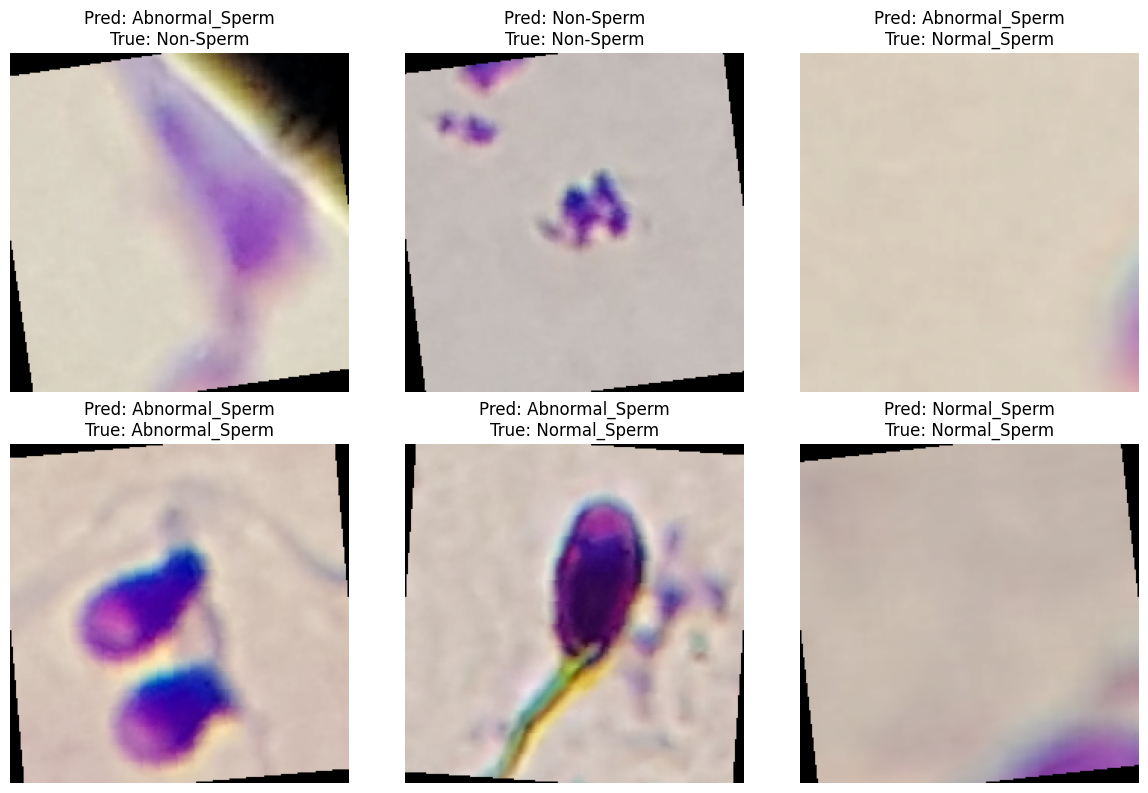

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of test data
inputs, labels = next(iter(dataloaders['test']))
inputs = inputs.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Plot results
plt.figure(figsize=(12, 8))
for i in range(min(6, len(inputs))):
    plt.subplot(2, 3, i+1)
    imshow(inputs.cpu()[i], f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
plt.tight_layout()
plt.show()